In [141]:
# kütüphaneleri yükledik
from learntools.time_series.utils import (plot_periodogram, seasonal_plot, plot_lags, make_lags, make_leads,
                                          make_multistep_target, plot_multistep)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.multioutput import RegressorChain

from hybrid_model import BoostedHybrid

import warnings

warnings.simplefilter('ignore')

In [142]:
# belli tanımlamaları yaptık ve datasetleri çektik
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
store_sales = pd.read_csv(
    'store-sales-time-series-forecasting\\train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint64',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

### Time-step feature

In [143]:
df = average_sales.to_frame()
time = np.arange(len(df.index))

df['time'] = time

X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

In [144]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Time Plot of Total Store Sales')

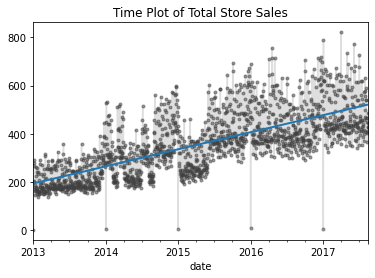

In [145]:
# zaman grafiğini çizdirdik (time plot)
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=2)
ax.set_title('Time Plot of Total Store Sales')

### Lag feature

In [146]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']

y, X = y.align(X, join='inner')

In [147]:
model = LinearRegression().fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

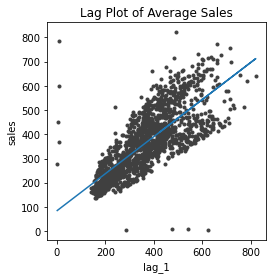

In [148]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

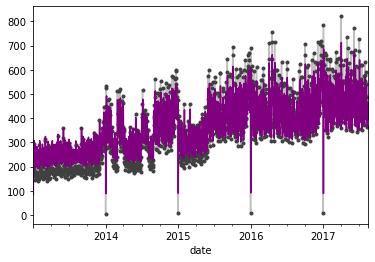

In [149]:
# geçikme özelliğini çizdirdik (lag features)
ax = y.plot(**plot_params)
ax = y_pred.plot(color='purple')

### Trend

### Identify trend
- Moving Average Plots

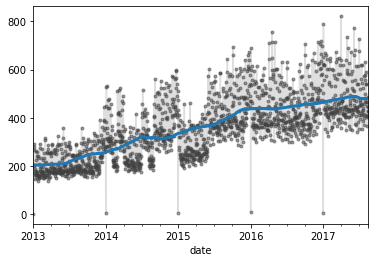

In [150]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Create a trend feature

In [151]:
from pyearth import Earth

dp = DeterministicProcess(
    index=y.index,
    order=1,
)
X = dp.in_sample()

In [152]:
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

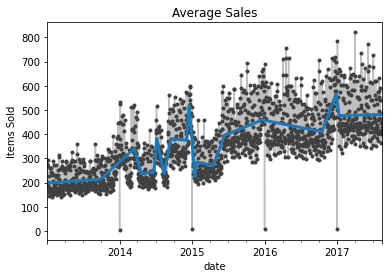

In [153]:
ax = y.plot(**plot_params, title='Average Sales', ylabel='Items Sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend')

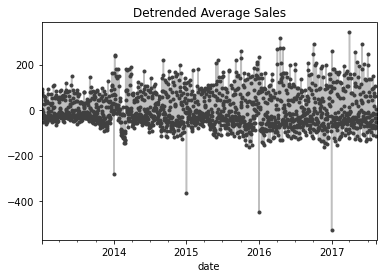

In [154]:
y_detrended = y - y_pred

y_detrended.plot(**plot_params, title='Detrended Average Sales');

## Seasonal

In [155]:
store_sales_sea = store_sales.drop(columns=['id', 'onpromotion'])
# average_sales = (
#     store_sales_sea.groupby('date').mean()
#         .squeeze()
#         .loc['2017']
# )

In [156]:
average_sales = y_detrended.to_frame()
average_sales.columns = ['sales']
average_sales = (average_sales.squeeze().loc['2017'])

average_sales

date
2017-01-01   -527.197644
2017-01-02    259.302399
2017-01-03     98.466167
2017-01-04     40.685905
2017-01-05    -72.194790
                 ...    
2017-08-11    -17.837917
2017-08-12    -36.795848
2017-08-13      4.152135
2017-08-14    -54.634104
2017-08-15    -53.680291
Freq: D, Name: sales, Length: 227, dtype: float64

##### Determine seasonality

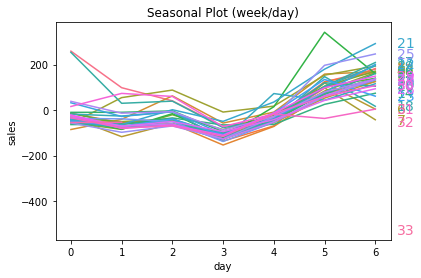

In [157]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

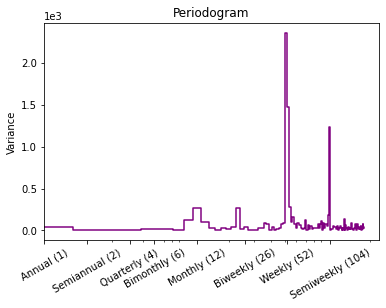

In [158]:
plot_periodogram(average_sales);

##### Create seasonal feature

In [159]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [160]:
y

date
2017-01-01   -527.197644
2017-01-02    259.302399
2017-01-03     98.466167
2017-01-04     40.685905
2017-01-05    -72.194790
                 ...    
2017-08-11    -17.837917
2017-08-12    -36.795848
2017-08-13      4.152135
2017-08-14    -54.634104
2017-08-15    -53.680291
Freq: D, Name: sales, Length: 227, dtype: float64

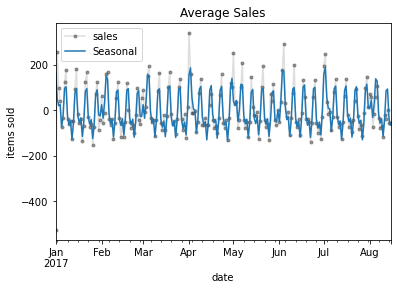

In [161]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

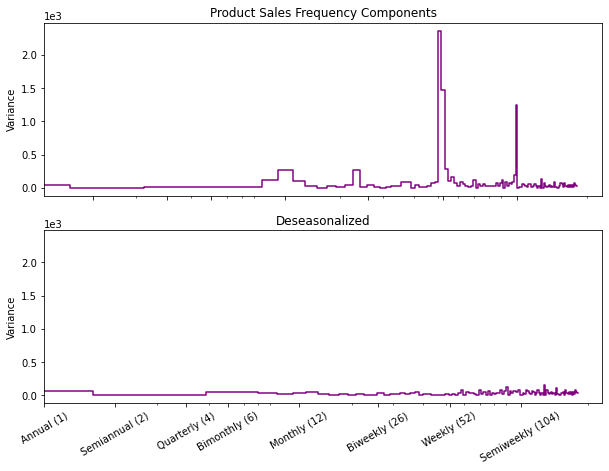

In [162]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title('Product Sales Frequency Components')
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title('Deseasonalized');

In [163]:
holidays_events = pd.read_csv(
    'store-sales-time-series-forecasting\\holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'local_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
    holidays_events
        .query('locale in ["National", "Regional"]')
        .loc['2017': '2017-08-15', ['description']]
)

# display(holidays)

Text(0.5, 1.0, 'National and Regional Holidays')

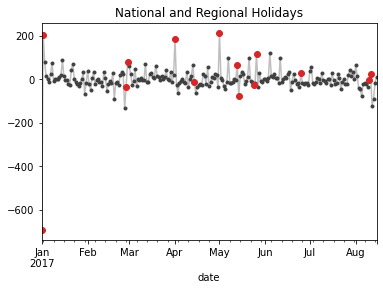

In [164]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

##### Create holiday features

In [165]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

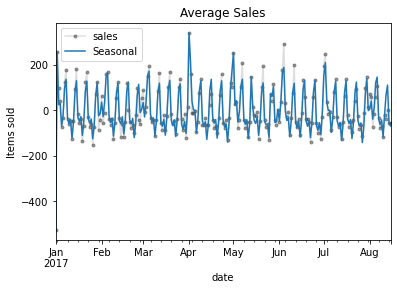

In [166]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='Items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

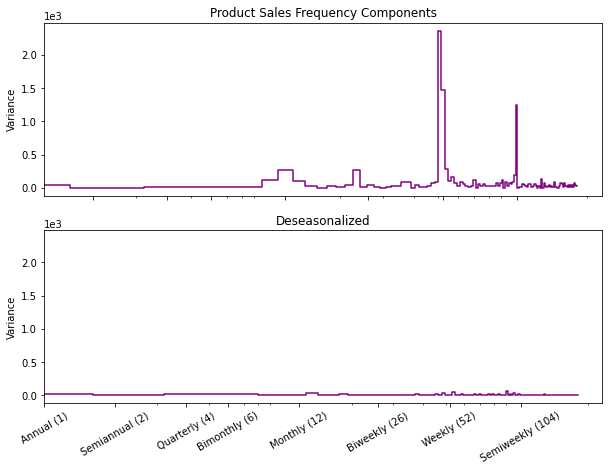

In [167]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### Time Series as Features

In [168]:
temp_store_sales = store_sales.drop(columns=['id'])

family_sales = (
    store_sales
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
        .loc['2017', ['sales', 'onpromotion']]
)

# family_sales

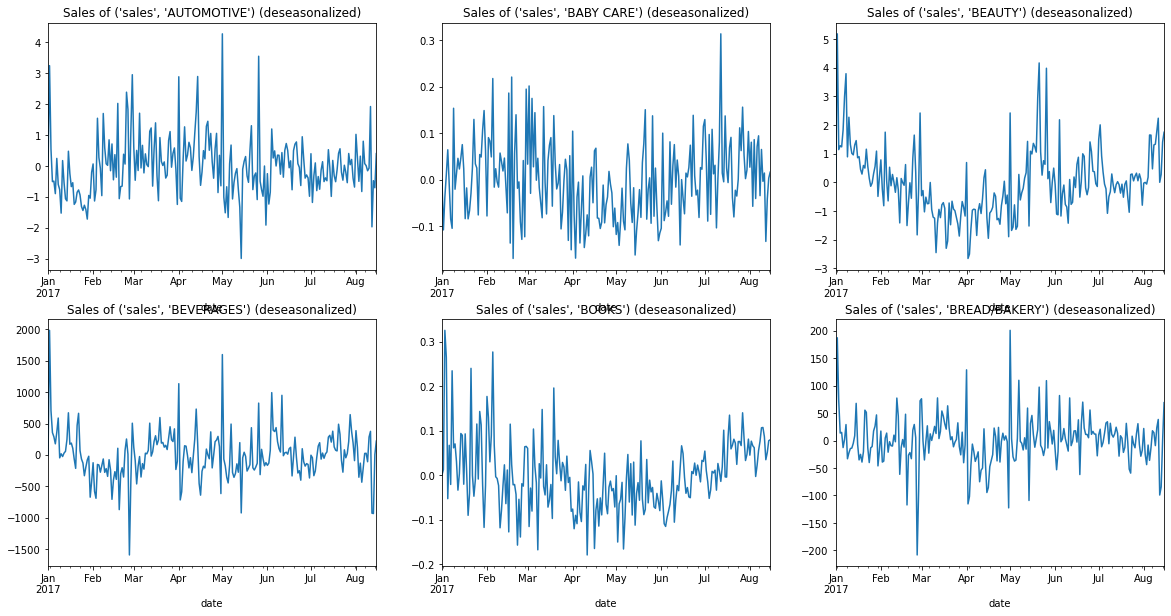

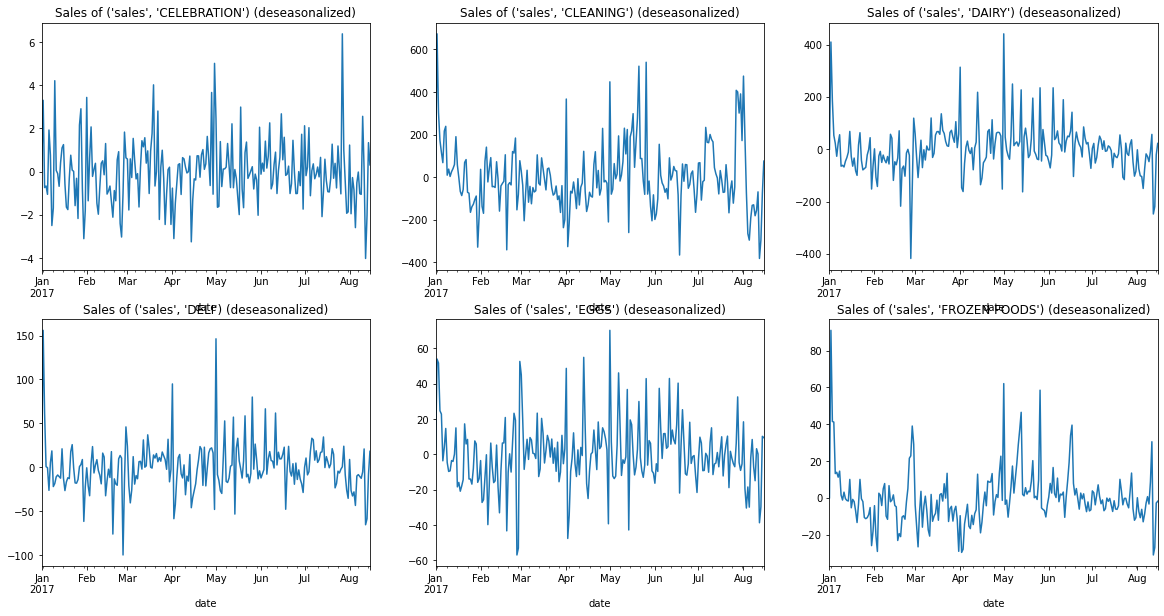

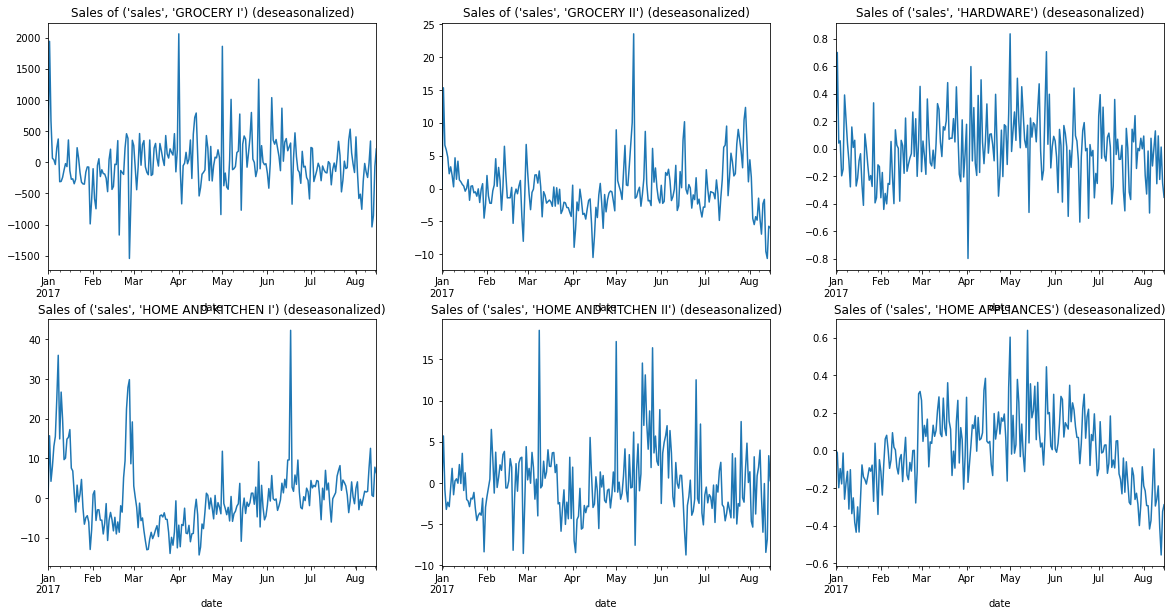

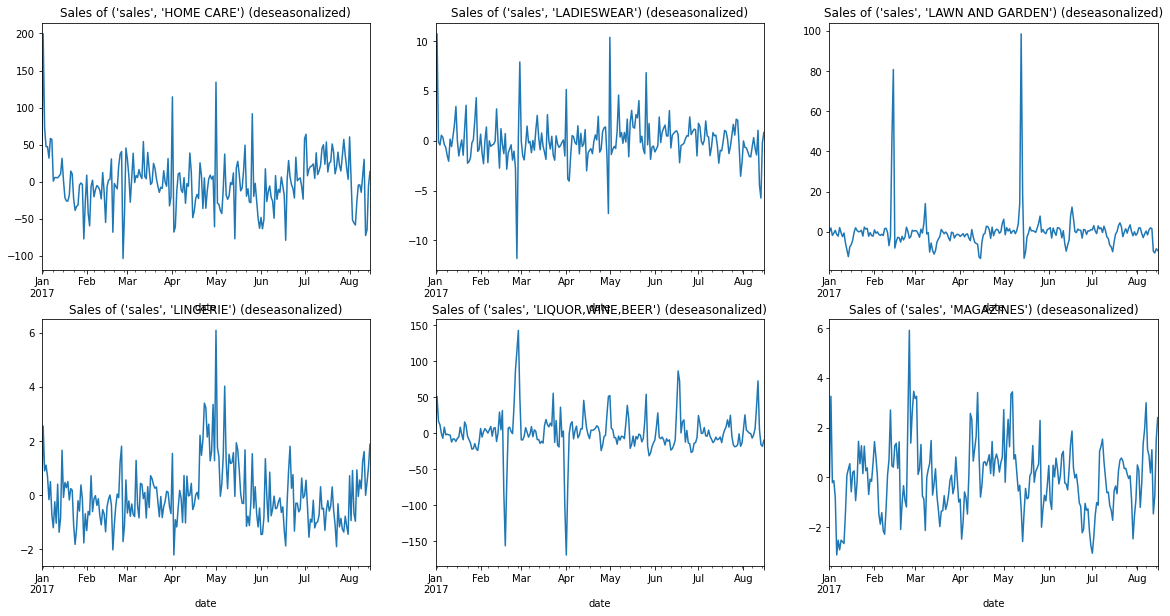

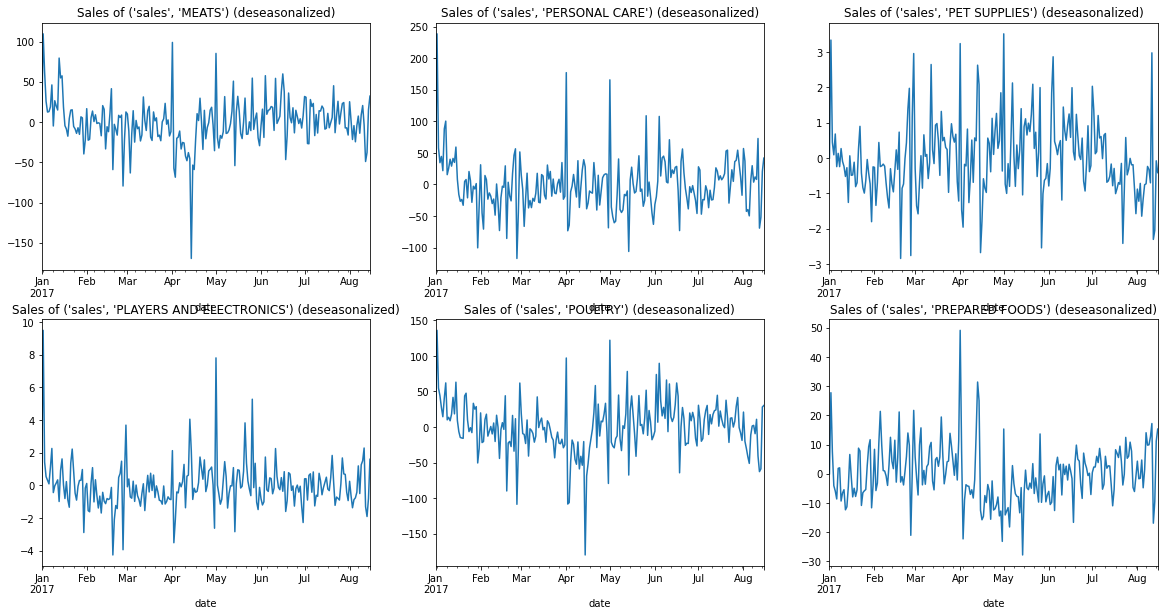

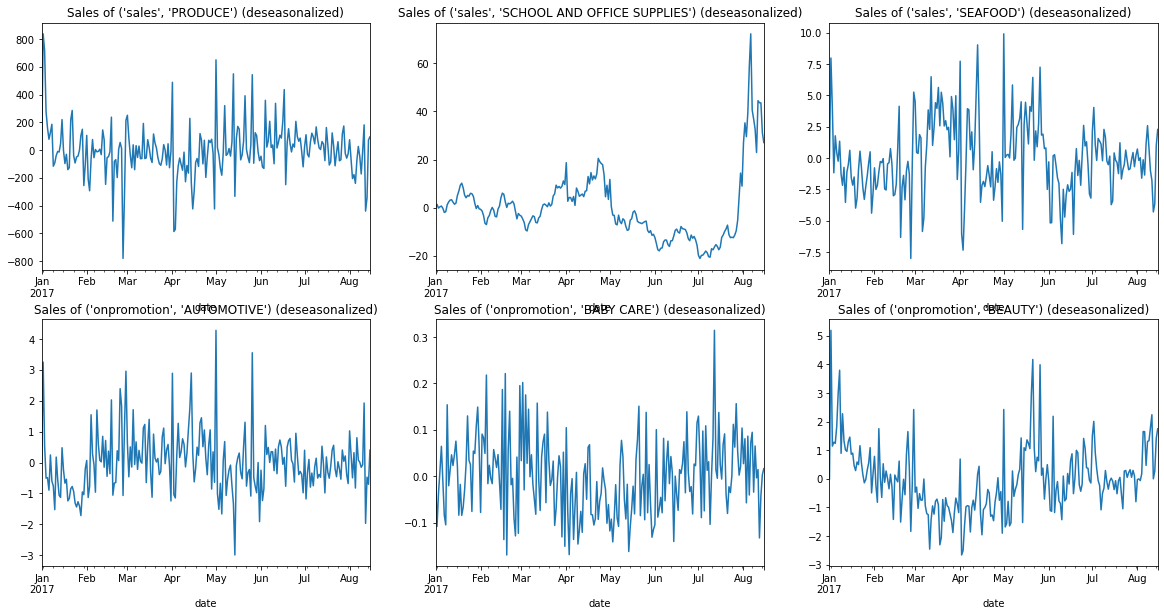

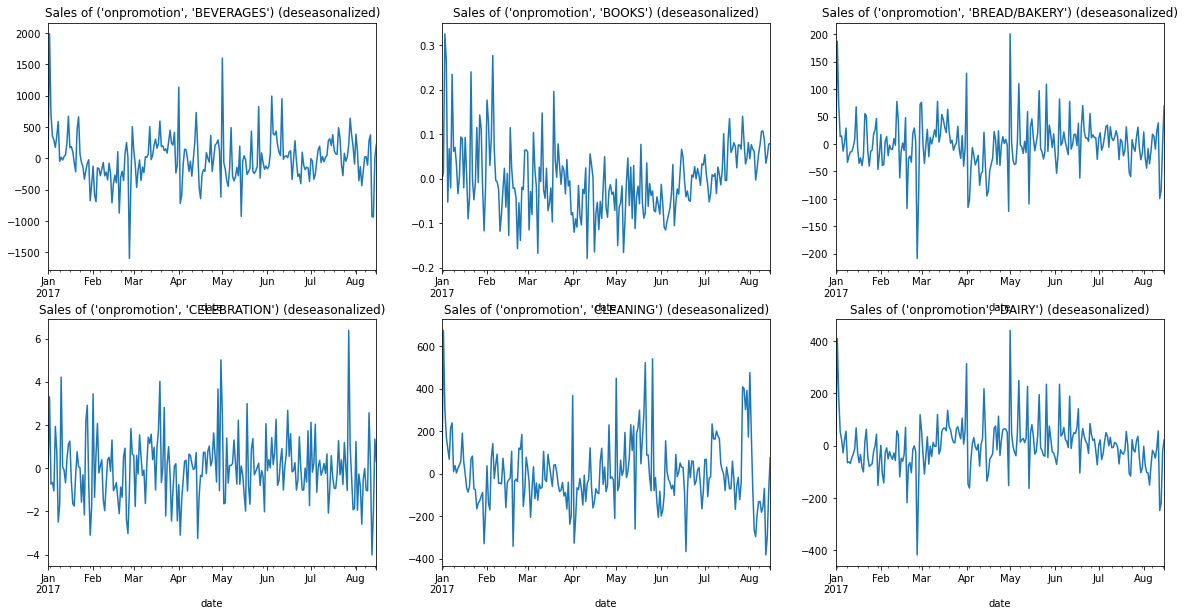

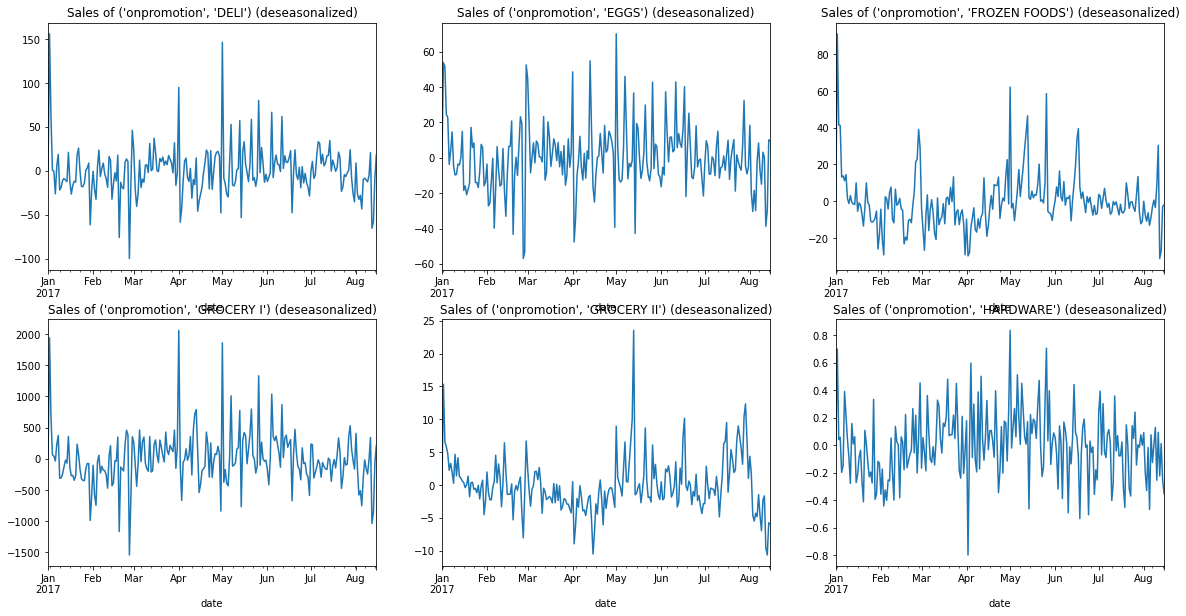

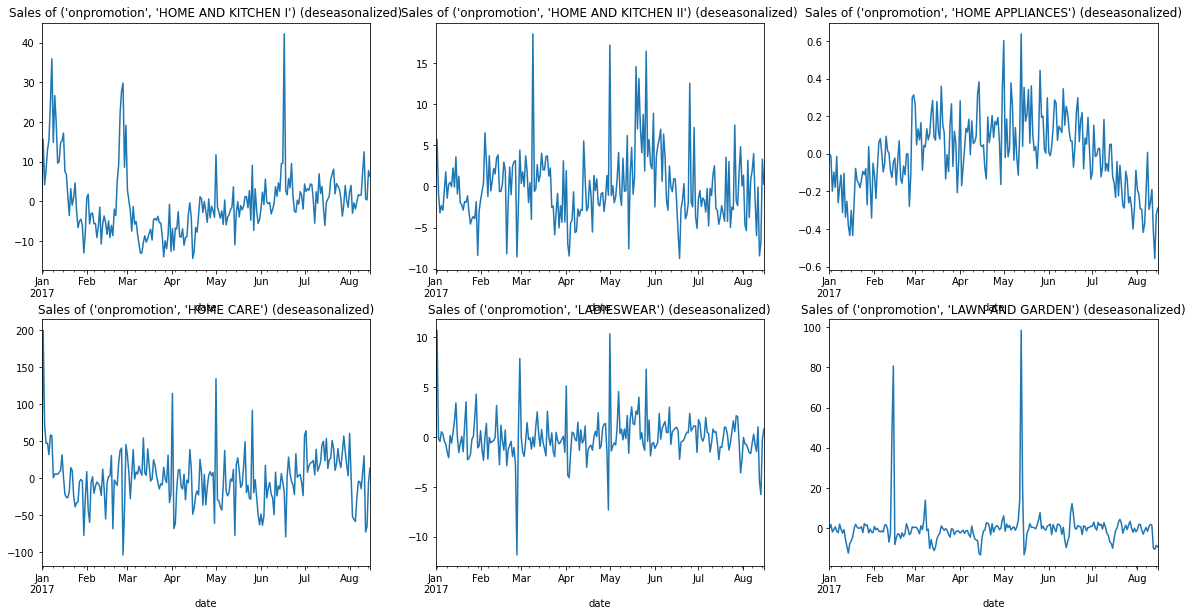

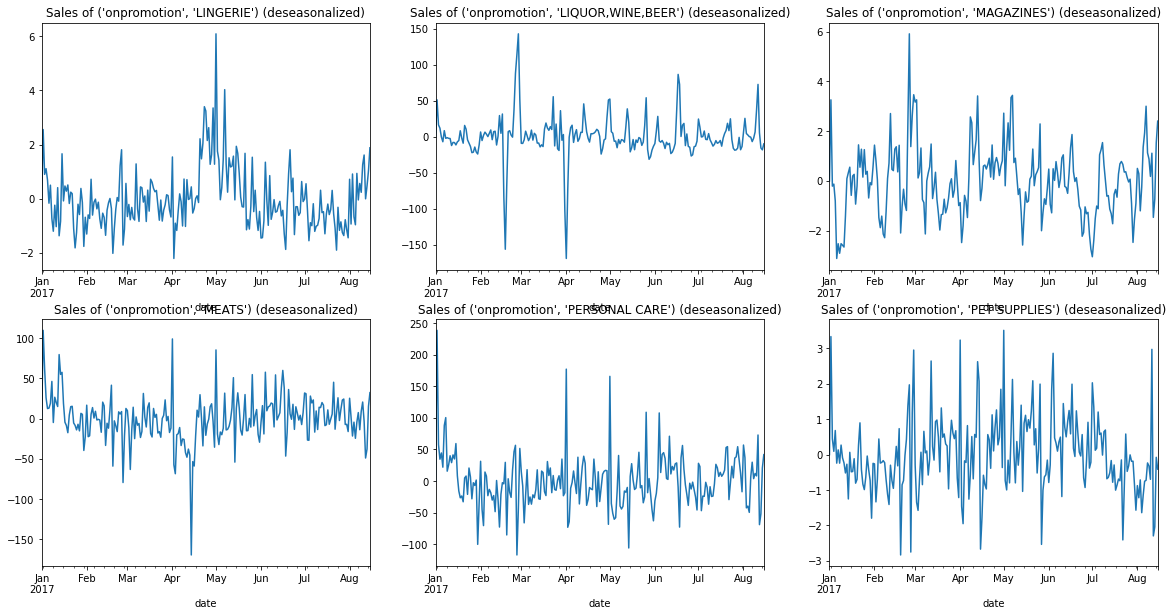

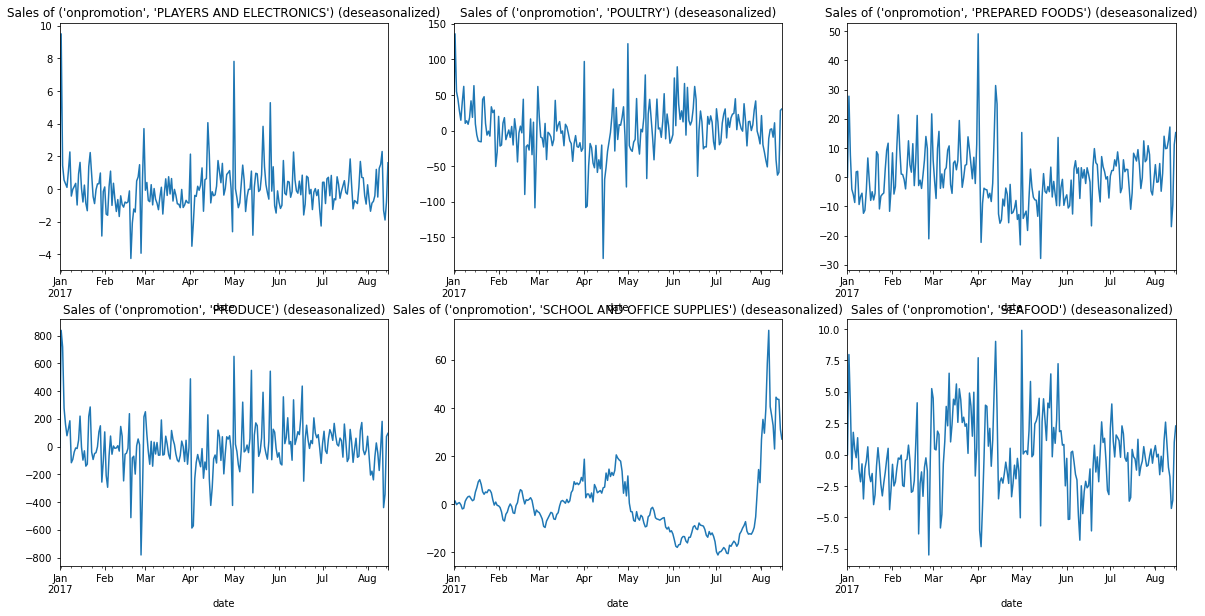

In [169]:
# bu fonksiyon karakterize edilmeyen ve bozulma kalıpları gösteren sütunları bulmak için
def deseasonized(data):
    b = 0
    a = 0
    _, axes = plt.subplots(2, 3, figsize=(20, 10))
    for column in data:
        df = data.loc(axis=1)[:, column]
        y = df.loc[:, 'sales'].squeeze()

        fourier = CalendarFourier(freq='M', order=4)
        dp = DeterministicProcess(
            constant=True,
            index=y.index,
            order=1,
            seasonal=True,
            drop=True,
            additional_terms=[fourier],
        )
        X_time = dp.in_sample()
        X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

        model = LinearRegression(fit_intercept=False)
        model.fit(X_time, y)
        y_deseason = y - model.predict(X_time)
        y_deseason.name = 'sales_deseasoned'

        if b > 2:
            b = 0
            a += 1
        if a > 1:
            _, axes = plt.subplots(2, 3, figsize=(20, 10))
            a = 0
            b = 0

        ax = y_deseason.plot(ax=axes[a, b])
        ax.set_title(f"Sales of {column} (deseasonalized)")
        # plt.show()
        b += 1


deseasonized(family_sales)

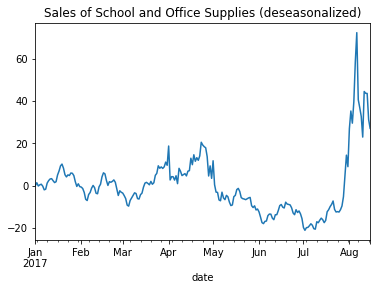

In [170]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

In [171]:
# onpro = supply_sales.loc[:, 'onpromotion'].squeeze()

#### Plotting cycles

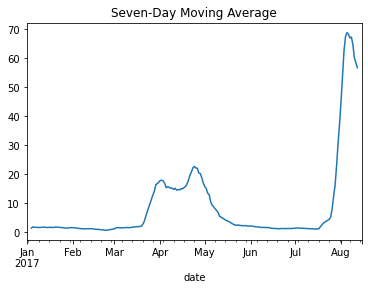

In [172]:
y_ma = y.rolling(window=7, center=True).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

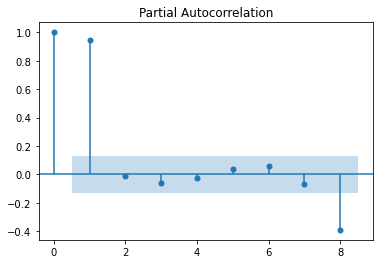

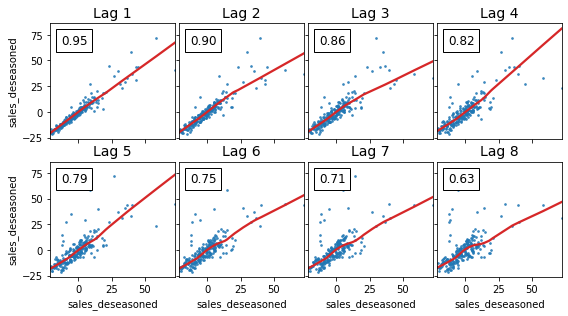

In [173]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

#### Serial Dependence

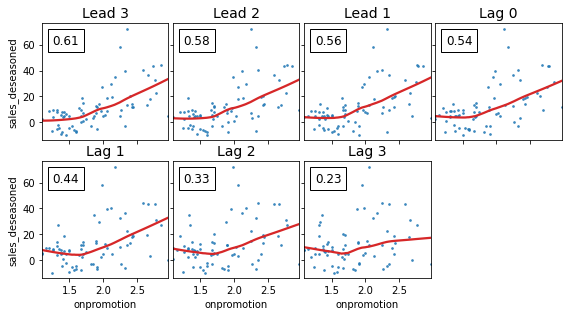

In [174]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=2);

#### Create time series features

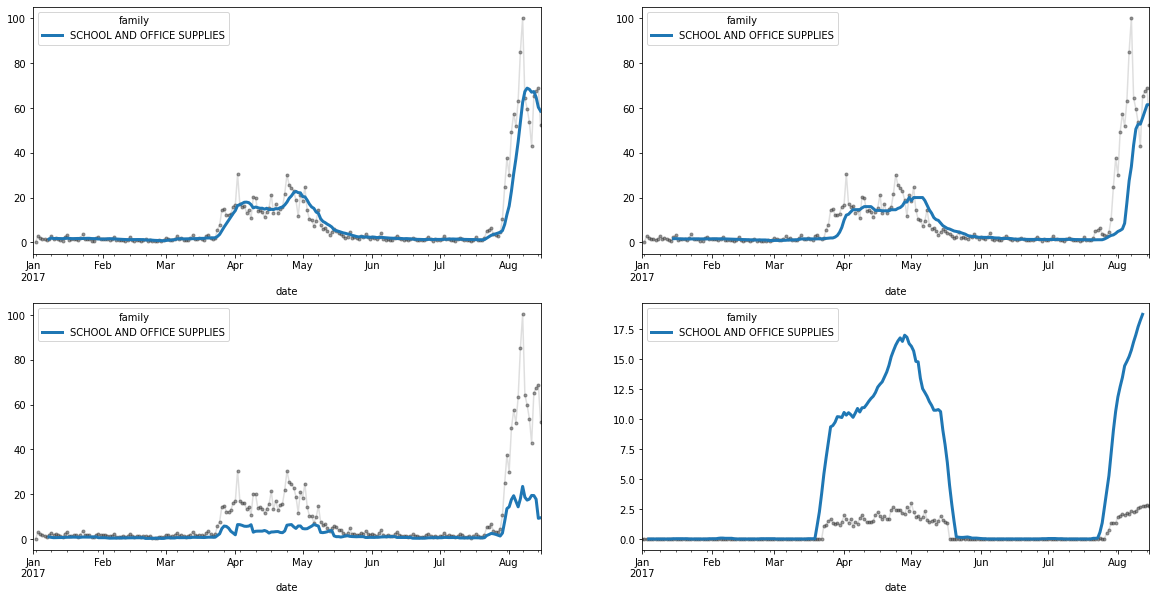

In [175]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()

ax = y_lag.plot(**plot_params, alpha=0.5, ax=axes[0, 0])
mean_7.plot(ax=ax, linewidth=3)

ax = y_lag.plot(**plot_params, alpha=0.5, ax=axes[0, 1])
median_14.plot(ax=axes[0, 1], linewidth=3)

ax = y_lag.plot(**plot_params, alpha=0.5, ax=axes[1, 0])
std_7.plot(ax=ax, linewidth=3)

ax = onpromo.plot(**plot_params, alpha=0.5, ax=axes[1, 1])
promo_7.plot(ax=ax, linewidth=3);

In [176]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
    mean_7, median_14, promo_7,  # burada daha iyi tahmin için belirli istatistikler ekledik
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')

y = y.fillna(0.0)
X = X.fillna(0.0)

Training RMSLE: 0.37295
Validation RMSLE: 0.46147


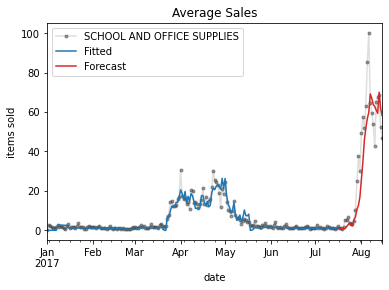

In [177]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

X_train = X_train.fillna(0.0)  # burada Nan olan değerleri 0.0 ile doldurdum hata vermesinler diye

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

### Hybrid Models

In [178]:
store_sales_hybrid = store_sales.drop('id', axis=1)

In [179]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [180]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    self.model_2.fit(X_2, y_resid)

    self.y_columns = y.columns
    self.y_fit = y_fit
    self.y_resid = y_resid


BoostedHybrid.fit = fit

In [181]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()

    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


BoostedHybrid.predict = predict

In [182]:
y = family_sales.loc[:, 'sales']

dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

X_2 = family_sales.drop('sales', axis=1).stack()

le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

X_2["day"] = X_2.index.day

In [183]:
y

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.092593,0.037037,0.055556,74.222221,0.000000,9.084685,0.129630,7.500000,11.518518,3.629167,...,0.074074,5.013166,2.629630,0.074074,0.222222,2.855537,1.040722,31.163778,0.000000,0.259259
2017-01-02,11.481482,0.259259,11.648149,6208.055664,0.481481,844.836304,14.203704,2233.648193,1545.000000,539.114807,...,7.777778,488.522339,714.370361,12.814815,22.777779,581.413147,153.555542,3409.500488,2.925926,33.581944
2017-01-03,8.296296,0.296296,7.185185,4507.814941,0.814815,665.124084,10.629630,1711.907349,1204.203735,404.300079,...,3.500000,427.520905,488.333344,8.870370,13.555555,462.013672,125.820534,3394.559814,2.018518,27.135260
2017-01-04,6.833333,0.333333,6.888889,3911.833252,0.759259,594.160583,11.185185,1508.036987,1107.796265,309.397675,...,3.500000,369.121490,426.574066,8.129630,12.092592,431.276398,116.740814,3467.447998,1.722222,22.034130
2017-01-05,6.333333,0.351852,5.925926,3258.796387,0.407407,495.511597,12.444445,1241.833374,829.277771,260.776489,...,3.203704,368.945679,360.925934,7.629630,10.333333,345.673492,101.434570,2069.316650,1.425926,20.615334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,8.166667,0.129630,6.500000,3502.055664,0.000000,522.305298,16.111111,1031.148193,831.648132,345.934967,...,9.259259,498.964661,295.888885,10.870370,12.111111,468.857361,96.286926,2198.854492,65.240738,23.566963
2017-08-12,7.462963,0.055556,6.833333,3376.259277,0.000000,507.473114,15.722222,1072.870361,793.592590,290.553589,...,8.944445,329.178711,294.500000,9.407408,13.185185,354.342773,84.693817,2070.154785,67.481483,19.037592
2017-08-13,8.907408,0.166667,8.018518,3747.296387,0.018519,615.976990,10.074074,1143.648193,928.000000,325.801361,...,8.685185,345.055817,336.814819,10.018518,13.722222,379.801208,91.509422,2331.922363,68.851852,20.704575


In [184]:
X_1

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0
...,...
2017-08-11,223.0
2017-08-12,224.0
2017-08-13,225.0


In [185]:
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [186]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [187]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

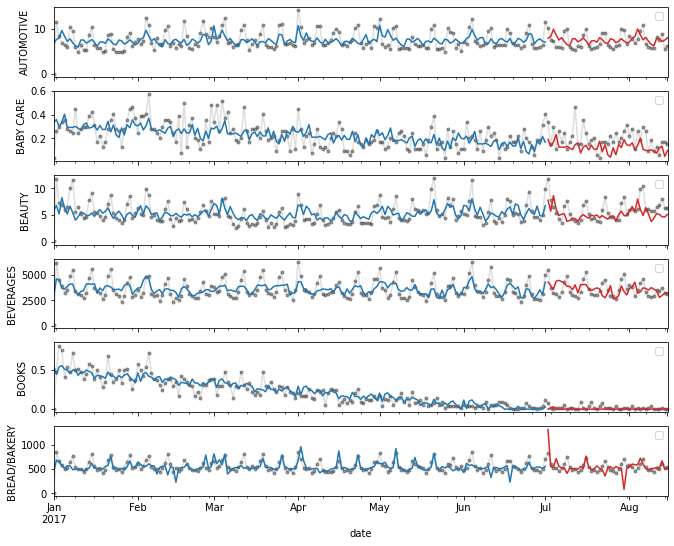

In [188]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02":]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### Forecasting With Machine Learning

In [189]:
test = pd.read_csv(
    'store-sales-time-series-forecasting//test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [190]:
print("Training Data", "\n" + "-" * 13)
store_sales

Training Data 
-------------


id        sales  \
date       store_nbr family                                             
2013-01-01 1         AUTOMOTIVE                        0     0.000000   
                     BABY CARE                         1     0.000000   
                     BEAUTY                            2     0.000000   
                     BEVERAGES                         3     0.000000   
                     BOOKS                             4     0.000000   
...                                                  ...          ...   
2017-08-15 9         POULTRY                     3000883   438.132996   
                     PREPARED FOODS              3000884   154.552994   
                     PRODUCE                     3000885  2419.729004   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000000   
                     SEAFOOD                     3000887    16.000000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

In [191]:
print("Test Data", "\n" + "-" * 9)
test

Test Data 
---------


id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [192]:
y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [193]:
le = LabelEncoder()
X = (X
     .stack('family')
     .reset_index('family')
     .assign(family=lambda x: le.fit_transform(x.family))
     )
y = y.stack('family')

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [194]:
X

,family,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,,
2017-01-05,0,6.833333,8.296296,11.481482,0.092593
2017-01-05,1,0.333333,0.296296,0.259259,0.037037
2017-01-05,2,6.888889,7.185185,11.648149,0.055556
2017-01-05,3,3911.833252,4507.814941,6208.055664,74.222221
2017-01-05,4,0.759259,0.814815,0.481481,0.000000
...,...,...,...,...,...
2017-07-31,28,464.615662,416.242065,528.171875,269.486877
2017-07-31,29,101.991165,100.165146,87.455833,77.199738
2017-07-31,30,2704.551758,2444.234375,2073.127686,1675.579346


In [195]:
model = RegressorChain(base_estimator=XGBRegressor())

model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

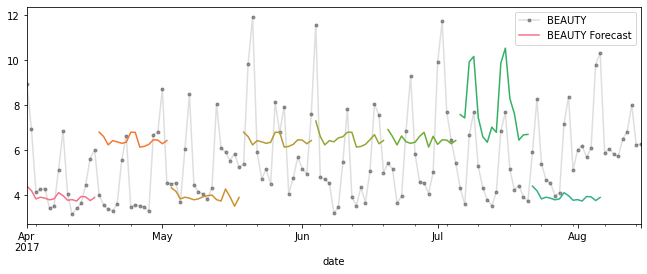

In [196]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])